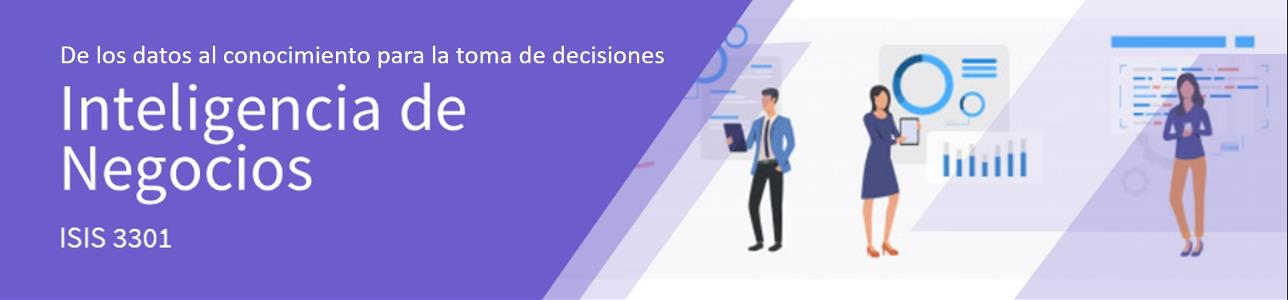

## Problema
El Ministerio de Comercio, Industria y Turismo de Colombia, la Asociación Hotelera y Turística de Colombia – COTELCO, cadenas hoteleras de la talla de Hilton, Hoteles Estelar, Holiday Inn y hoteles pequeños ubicados en diferentes municipios de Colombia están interesados en analizar las características de sitios turísticos que los hacen atractivos para
turistas locales o de otros países, ya sea para ir a conocerlos o recomendarlos. De igual manera, quieren comparar las características de dichos sitios, con aquellos que han obtenido bajas recomendaciones y que están afectando el número de turistas que llegan a ellos. Adicionalmente, quieren tener un mecanismo para determinar la calificación que tendrá un sitio por parte de los turistas y así, por ejemplo, aplicar estrategias para identificar oportunidades de mejora que permitan aumentar la popularidad de los sitios y fomentar el turismo.

Esos actores de turismo prepararon dos conjuntos de datos con reseñas de sitios turísticos. Cada reseña tiene una calificación según el sentimiento que tuvo el turista al visitarlo. Estos actores quieren lograr un análisis independiente de los conjuntos de datos y al final del proyecto discutir sobre los grupos de científicos de datos e ingenieros de datos que acompañarán el desarrollo real de este proyecto.

## 1. Instalación e importanción de librerías.


In [7]:
# librería Natural Language Toolkit, usada para trabajar con textos
!pip install ydata-profiling
!pip install contractions
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

In [8]:

# Instalación de librerias
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
from text_preprocessing import TextPreprocessing


import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score


from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

from wordcloud import STOPWORDS

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt

## 2. Perfilamiento y entendimiento de los datos



### 2.1. Lectura de los datos

In [9]:
data=pd.read_csv("tipo1_entrenamiento_estudiantes.csv")
data.head()

,Review,Class
0,Nos alojamos en una casa alquilada en la ciuda...,4
1,"La comida está bien, pero nada especial. Yo te...",3
2,"En mi opinión, no es una como muchos usuarios ...",3
3,esta curiosa forma que asemeja una silla de mo...,4
4,Lo mejor era la limonada. Me gusto la comida d...,2


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


### 2.2. Entendimiento de los Datos

In [11]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Preparación de datos

### 3.1. Limpieza de los datos

El reporte nos indica que existen filas repetidas, podemos eliminarlas.

In [12]:
data = data.drop_duplicates(subset=['Review'])
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Al estar lidiando con textos, las palabras que más aparecerán son netamente gramaticales, como conjunciones y artículos, para el caso del español. Para eliminar dicho ruido, se usa la librería de stopwords para limpiar la data y tener resultados más significativos. Adicionalmente, para eliminar el ruido, se puede eliminar la puntuación, mayúsculas, acentos y en general todo caracter que no ASCII. Finalmente, podemos convertir todo número a su representación en letras, con esto nos aseguramos de que todos los datos son caracteres validos de ASCII, reduciendo así el ruido.

In [13]:
from langdetect import detect, LangDetectException

# Revisa el idioma del dataset
analisis= data.copy()

# #Se define una función que detecta el idioma de un texto
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "Unknown"

# Apply the language detection function to the first few rows as a test
analisis['lenguaje']=data['Review'].apply(detect_language)
language_counts = analisis['lenguaje'].value_counts()
language_counts

lenguaje
es    7797
en       6
pt       1
Name: count, dtype: int64

In [14]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words, stopwords=stopwords.words('spanish')):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 3.2. Normalización

Agregamos normalización para eliminar sufijos, prefijos y lematizar verbos a sus raíces.

In [15]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

### 3.3. Tokenización

Adicionalmente a la limpieza, resulta útil tokenizar los datos, esto nos permite luego separar frases completas.

In [16]:
review_t = data["Review"].apply(word_tokenize)

review_t = review_t.apply(preproccesing)

data["ReviewT"] = review_t.apply(stem_and_lemmatize)

C:\Users\esteb\AppData\Local\Temp\ipykernel_26996\3187383547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ReviewT"] = review_t.apply(stem_and_lemmatize)


In [17]:
data['ReviewT'] = data['ReviewT'].apply(lambda x: ' '.join(map(str, x)))

C:\Users\esteb\AppData\Local\Temp\ipykernel_26996\3748468002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ReviewT'] = data['ReviewT'].apply(lambda x: ' '.join(map(str, x)))


## 4. Modelado


In [18]:
# class TextPreprocessing(BaseEstimator,TransformerMixin):
#     def __init__(self,stopwords=stopwords.words('spanish')):
#         self.stopwords = stopwords

#     def remove_non_ascii(self, words):
#         new_words = []
#         for word in words:
#             new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#             new_words.append(new_word)
#         return new_words

#     def to_lowercase(self, words):
#         new_words = []
#         for word in words:
#             new_word = word.lower()
#             new_words.append(new_word)
#         return new_words

#     def remove_punctuation(self, words):
#         new_words = []
#         for word in words:
#             new_word = re.sub(r'[^\w\s]', '', word)
#             if new_word != '':
#                 new_words.append(new_word)
#         return new_words

#     def replace_numbers(self, words):
#         p = inflect.engine()
#         new_words = []
#         for word in words:
#             if word.isdigit():
#                 new_word = p.number_to_words(word)
#                 new_words.append(new_word)
#             else:
#                 new_words.append(word)
#         return new_words

#     def remove_stopwords(self, words):
#         new_words = []
#         for word in words:
#             if word not in self.stopwords:
#                 new_words.append(word)
#         return new_words

#     def stem_words(self, words):
#         stemmer = SnowballStemmer('spanish')
#         stems = []
#         for word in words:
#             stem = stemmer.stem(word)
#             stems.append(stem)
#         return stems

#     def lemmatize_verbs(self, words):
#         lemmatizer = WordNetLemmatizer()
#         lemmas = []
#         for word in words:
#             lemma = lemmatizer.lemmatize(word, pos='v')
#             lemmas.append(lemma)
#         return lemmas

#     def stem_and_lemmatize(self, words):
#         words = self.stem_words(words)
#         words = self.lemmatize_verbs(words)
#         return words

#     def preproccesing(self, words):
#         words = self.to_lowercase(words)
#         words = self.replace_numbers(words)
#         words = self.remove_punctuation(words)
#         words = self.remove_non_ascii(words)
#         words = self.remove_stopwords(words)
#         return words

#     def fit(self,X,y=None):
#         return self

#     def transform(self,X,y=None):
#         X_train = pd.Series(X)
#         X_train = X_train.apply(contractions.fix)
#         X_train = X_train.apply(word_tokenize)
#         X_train = X_train.apply(lambda x: self.preproccesing(x))
#         X_train = X_train.apply(lambda x: self.stem_and_lemmatize(x))
#         X_train = X_train.apply(lambda x: ' '.join(map(str, x)))
#         return X_train

Separamos los datos limpios para probar y entrenar.

In [19]:
clean_data = data.copy()
clean_data = clean_data.drop(columns=['Review'])

In [20]:
train, test = train_test_split(clean_data, test_size=0.2, random_state=33)
train.head()

,Class,ReviewT
1942,5,sed laurel aven jardin 100 pet friendly excele...
2068,5,estanci hotel mision express agrad recepcion p...
6686,3,padr pas rat desventaj letr pequen dic dia abr...
1590,5,gran restaur famili realiz reserv corre electr...
736,2,val pen hotel agu calient sirv air acondicion ...


In [21]:
X_train, y_train = train['ReviewT'], train['Class']
display(X_train)
y_train

1942    sed laurel aven jardin 100 pet friendly excele...
2068    estanci hotel mision express agrad recepcion p...
6686    padr pas rat desventaj letr pequen dic dia abr...
1590    gran restaur famili realiz reserv corre electr...
736     val pen hotel agu calient sirv air acondicion ...
                              ...                        
2718    gran hotel gran ubic personal excelent habit l...
579     visit indispens call bonit cuent restaur compa...
5897    gust malecon alli torment asi olas romp par ca...
2449    siti increibl ver unic pued dec agradec hij co...
7252    habit correspond fotografi public internet pub...
Name: ReviewT, Length: 6243, dtype: object

1942    5
2068    5
6686    3
1590    5
736     2
       ..
2718    5
579     2
5897    4
2449    4
7252    2
Name: Class, Length: 6243, dtype: int64

### 4.1. Modelo SVM

In [22]:
## Crea el test y el train set

X_train, X_test, y_train, y_test = train_test_split(train['ReviewT'], train['Class'], test_size=0.2, random_state=42)
print(X_test)

3840    ubic hotel exelent ubic haban viej cerc pued i...
3540    sorpres pues esper ver unic obras boter embarg...
5020    esper mas si bien ciert atraccion principal de...
5622    disfrut doming call cerr mexican famili mont b...
6110    situ haban viaj centr encuentr fuent leon lad ...
                              ...                        
3744    com vari preci razon present cad platill origi...
4736    univers encant muse cienci natural increibl pa...
2369    calid com servici part meser ambos excelent au...
5128    vend excelent cort carn concept noved elig car...
2610    ciud antigu monterrey renov 1980 macroplaz cua...
Name: ReviewT, Length: 1249, dtype: object


In [23]:
y_test.shape

(1249,)

In [24]:
y_train.shape

(4994,)

In [25]:
X_train.shape

(4994,)

In [26]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('tfid', TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)),
        ('classifier', SVC(kernel='linear', probability=True))
]

pipe_SVM = Pipeline(estimators)

pipe_SVM.fit(X_train, y_train)

CPU times: total: 1min 3s
Wall time: 1min 7s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('tfid', TfidfTransformer()),
                ('classifier', SVC(kernel='linear', probability=True))])

In [21]:
# param_grid = {
#     'classifier__kernel': ['linear', 'rbf'],  # You can add 'poly' and 'sigmoid' if interested
#     'classifier__probability': [True,False],
# }

# # Configure GridSearchCV
# grid_search = GridSearchCV(pipe_SVM, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

In [22]:
y_pred_train_SVM = pipe_SVM.predict(X_test)
y_pred_train_SVM

array([4, 5, 3, ..., 5, 3, 5], dtype=int64)

In [23]:
precision = accuracy_score(y_test, y_pred_train_SVM)

print("Precisión del modelo:", precision)

Precisión del modelo: 0.4835868694955965


In [3]:
# Get feature names
feature_names = pipe_SVM.named_steps['transform'].get_feature_names_out()

# Get the coefficients from the 'classifier' step assuming the classifier used is SVC with a linear kernel
svm_coef = pipe_SVM.named_steps['classifier'].coef_.toarray()

# Combine feature names and coefficients in a DataFrame for easier interpretation
import pandas as pd
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': svm_coef[0]})

# Display features sorted by absolute value of coefficients, descending
feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
feature_importance_sorted = feature_importance.sort_values(by='abs_coef', ascending=False)

print(feature_importance_sorted)

NameError: name 'pipe_SVM' is not defined

In [28]:
#Se prepara para la producción ,se manda todo el dataset
final_model=pipe_SVM.fit(train['ReviewT'], train['Class'])
print(final_model)

Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('tfid', TfidfTransformer()),
                ('classifier', SVC(kernel='linear', probability=True))])


In [29]:
import joblib

joblib.dump(final_model, "hotel_model.joblib")


['hotel_model.joblib']

### 4.2. Modelo Naive Bayes

In [ ]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('tfid', TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)),
        ('classifier', MultinomialNB())
    ]

pipe_NB = Pipeline(estimators)

pipe_NB.fit(X_train, y_train)

CPU times: total: 9.56 s
Wall time: 12.1 s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('tfid', TfidfTransformer()), ('classifier', MultinomialNB())])

In [ ]:
y_pred_train_NB = pipe_NB.predict(X_test)
y_pred_train_NB

array([4, 5, 3, ..., 5, 3, 4], dtype=int64)

In [ ]:
precision = accuracy_score(y_test, y_pred_train_NB)

print("Precisión del modelo:", precision)

Precisión del modelo: 0.4067253803042434


Confusion matrix, without normalization


<Axes: title={'center': 'Matriz de Confusión'}, xlabel='Predicted label', ylabel='True label'>

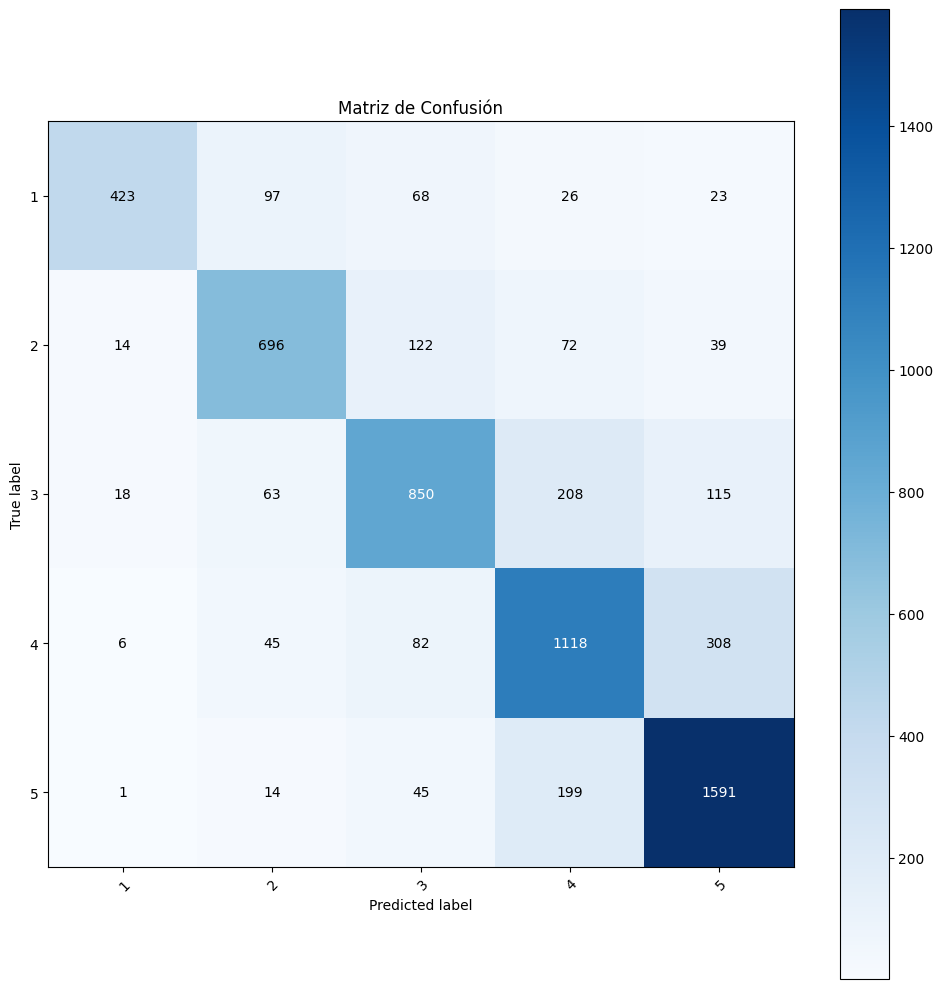

In [ ]:
%matplotlib inline

classes = pipe_NB['classifier'].classes_

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_NB, classes=classes,
                      title='Matriz de Confusión')

In [ ]:
report_NB = classification_report(y_train, y_pred_train_NB)

print("Reporte de Entrenamiento para Naive Bayes\n", report_NB)

Reporte de Entrenamiento para Naive Bayes
               precision    recall  f1-score   support

           1       0.92      0.66      0.77       637
           2       0.76      0.74      0.75       943
           3       0.73      0.68      0.70      1254
           4       0.69      0.72      0.70      1559
           5       0.77      0.86      0.81      1850

    accuracy                           0.75      6243
   macro avg       0.77      0.73      0.75      6243
weighted avg       0.75      0.75      0.75      6243



In [ ]:
precision = accuracy_score(y_test, y_pred_train_NB)

print("Precisión del modelo:", precision)

Precisión del modelo: 0.4067253803042434


### 4.3. Modelo Random Forest

In [ ]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('tfid', TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)),
        ('classifier', RandomForestRegressor()),
    ]

pipe_RF = Pipeline(estimators)

pipe_RF.fit(X_train, y_train)

CPU times: total: 3min 12s
Wall time: 3min 49s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('tfid', TfidfTransformer()),
                ('classifier', RandomForestRegressor())])

In [ ]:
y_pred_train_RF = pipe_RF.predict(X_test)
y_pred_train_RF

array([3.54, 4.13, 3.09, ..., 4.32, 4.5 , 4.03])

In [ ]:
mse_train_RF = mean_squared_error(y_test, y_pred_train_RF)

mae_train_RF = mean_absolute_error(y_test, y_pred_train_RF)

r2_train_RF = r2_score(y_test, y_pred_train_RF)

print("Métricas de rendimiento en el conjunto de entrenamiento:")
print("Error cuadrático medio - Mean Squared Error (MSE):", mse_train_RF)
print("Error absoluto medio - Mean Absolute Error (MAE):", mae_train_RF)
print("R cuadrado - R-squared (R^2):", r2_train_RF)


Métricas de rendimiento en el conjunto de entrenamiento:
Error cuadrático medio - Mean Squared Error (MSE): 1.0032117694155325
Error absoluto medio - Mean Absolute Error (MAE): 0.7853562850280225
R cuadrado - R-squared (R^2): 0.4494576358088447


In [ ]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('tfid', TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)),
        ('alg', RandomForestClassifier(random_state=12))
    ]

pipe_RFC = Pipeline(estimators)

pipe_RFC.fit(X_train, y_train)

CPU times: total: 20.8 s
Wall time: 24.3 s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('tfid', TfidfTransformer()),
                ('alg', RandomForestClassifier(random_state=12))])

In [ ]:
# Predict on the test set and calculate accuracy
y_pred_rf_sample = pipe_RFC.predict(X_test)
accuracy_rf_sample = accuracy_score(y_test, y_pred_rf_sample)

print("Accuracy:",accuracy_rf_sample)

Accuracy: 0.4347477982385909


In [1]:
final_model_reloaded = joblib.load("hotel_model.joblib")

new_data = "Chimba, me gustó mucho, el sitio espectacular y la comida, mela" # some data 
predictions = final_model_reloaded.predict(new_data)
print(predictions)

NameError: name 'joblib' is not defined